# Analyzing ClimateNet Dataset

In this notebook we analyze the ClimateNet dataset by computing several useful statistics and visualizing interesting examples.

In [1]:
from pathlib import Path

# specify the path to the data and output directories
out_dir = Path('/mnt/data/ai4good/out')
data_dir = Path('/mnt/data/ai4good/climatenet_new')  # expected to have a subfolder 'train' containing the train set
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

##  Data Exploration

First, we load the available train data and explore it a bit.

In [2]:
from utils.data import ClimateNetDataset
import xarray as xr
import numpy as np

ds = ClimateNetDataset(train_dir)

concat_ds = []
for i in np.random.randint(0, len(ds), 3):
    x = ds[i]
    concat_ds.append(x)

concat_ds = xr.concat(concat_ds, dim='time')

len(ds)
len(concat_ds)

17

In [3]:
sample = ds[0]
sample

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

In [4]:
sample.dims

Frozen({'lat': 768, 'lon': 1152, 'time': 1})

In [5]:
sample.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc'

In [6]:
for var in sample.data_vars:
    if var == 'LABELS':
        print(f'{var}: {sample[var].attrs["description"]} ({sample[var].dtype})')
    else:
        print(f'{var}: {sample[var].attrs["description"]} ({sample[var].attrs["units"]}) ({sample[var].dtype})')

TMQ: total (vertically integrated) precipitable water ( kg/m^2) (float32)
U850: zonal wind at 850 mbar pressure surface (m/s) (float32)
V850: meridional wind at 850 mbar pressure surface (m/s) (float32)
UBOT: lowest level zonal wind (m/s) (float32)
VBOT: lowest model level meridional wind (m/s) (float32)
QREFHT: reference height humidity (kg/kg) (float32)
PS: surface pressure (Pa) (float32)
PSL: sea level pressure (Pa) (float32)
T200: temperature at 200 mbar pressure surface (K) (float32)
T500: temperature at 500 mbar pressure surface (K) (float32)
PRECT: total (convective and large-scale) precipitation rate (liq + ice) (m/s) (float32)
TS: surface temperature (radiative) (K) (float32)
TREFHT: reference height temperature (K) (float32)
Z1000: geopotential Z at 1000 mbar pressure surface (m) (float32)
Z200: geopotential Z at 200 mbar pressure surface (m) (float32)
ZBOT: lowest modal level height (m) (float32)
LABELS: 0: Background, 1: Tropical Cyclone, 2: Athmospheric river (int64)


In [7]:
import ipywidgets as widgets
variables = list(sample.data_vars)
var_dropdown = widgets.Dropdown(options=variables, value=variables[0], description='Variable')

def plot_sample(var):
    sample[var].plot(figsize=(10,5))

widgets.interact(plot_sample, var=var_dropdown);

interactive(children=(Dropdown(description='Variable', options=('TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT…

## Data Analysis

In [8]:
from utils.stats import Stats

stats = Stats(ds=ds, num_samples=3)

TMQ
U850
V850
UBOT
VBOT
QREFHT
PS
PSL
T200
T500
PRECT
TS
TREFHT
Z1000
Z200
ZBOT
LABELS


In [9]:
bg, tc, ar = stats.get_label_distribution()
bg = bg.sum()
tc = tc.sum()
ar = ar.sum()
sum = bg + tc + ar

print(f'Background: {bg.values} ({bg/sum*100:.2f}%)')
print(f'Tropical Cyclone: {tc.values} ({tc/sum*100:.2f}%)')
print(f'Atmospheric Rivers: {ar.values} ({ar/sum*100:.2f}%)')

Background: 2464208 (92.84%)
Tropical Cyclone: 12641 (0.48%)
Atmospheric Rivers: 177359 (6.68%)


In [10]:
cm = stats.get_corr_matrix()

/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vscode/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vscode/.local/lib/python3.10/site-packages/n

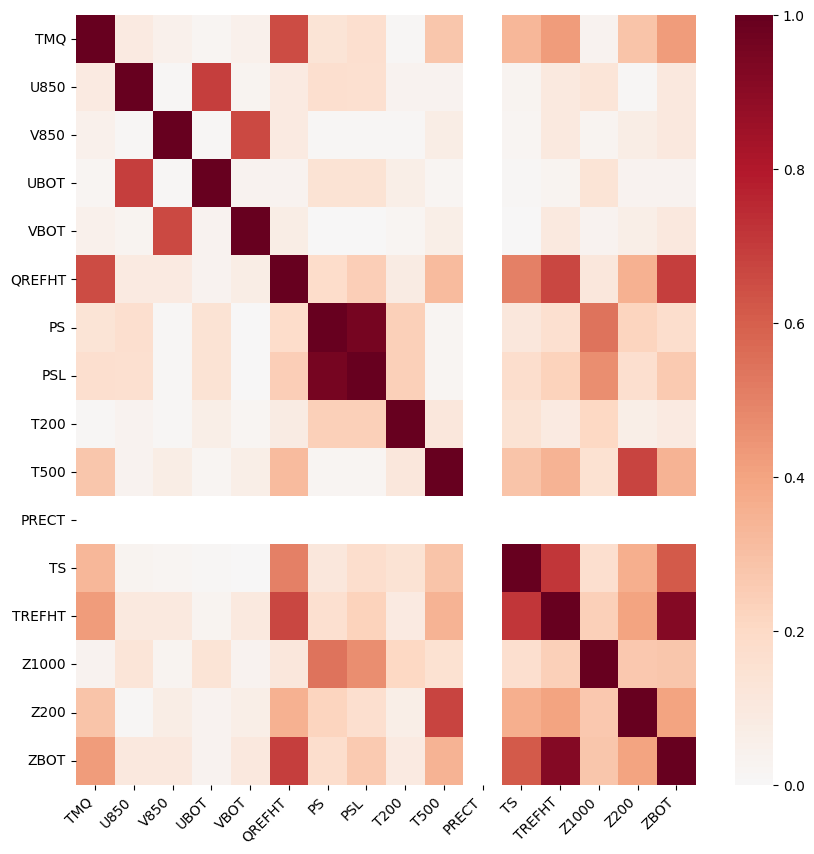

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(abs(cm), ax=ax, xticklabels=stats.data_vars, yticklabels=stats.data_vars, cmap='RdBu_r', center=0, vmin=0, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
plt.show()

In [12]:
import ipywidgets as widgets
variables = list(stats.data_vars)
var_dropdown = widgets.Dropdown(options=variables, value=variables[0], description='Variable')

def plot_sample(var):
    var_stats = stats.get_stats(var)
    for stat in var_stats:
        print(f'{stat}: {var_stats[stat]}')

widgets.interact(plot_sample, var=var_dropdown);

interactive(children=(Dropdown(description='Variable', options=('TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT…

In [13]:
features = ['PSL', 'TMQ', 'U850', 'V850', 'T500', 'ZBOT']

In [14]:
cm_features = stats.get_corr_matrix_vars(features)

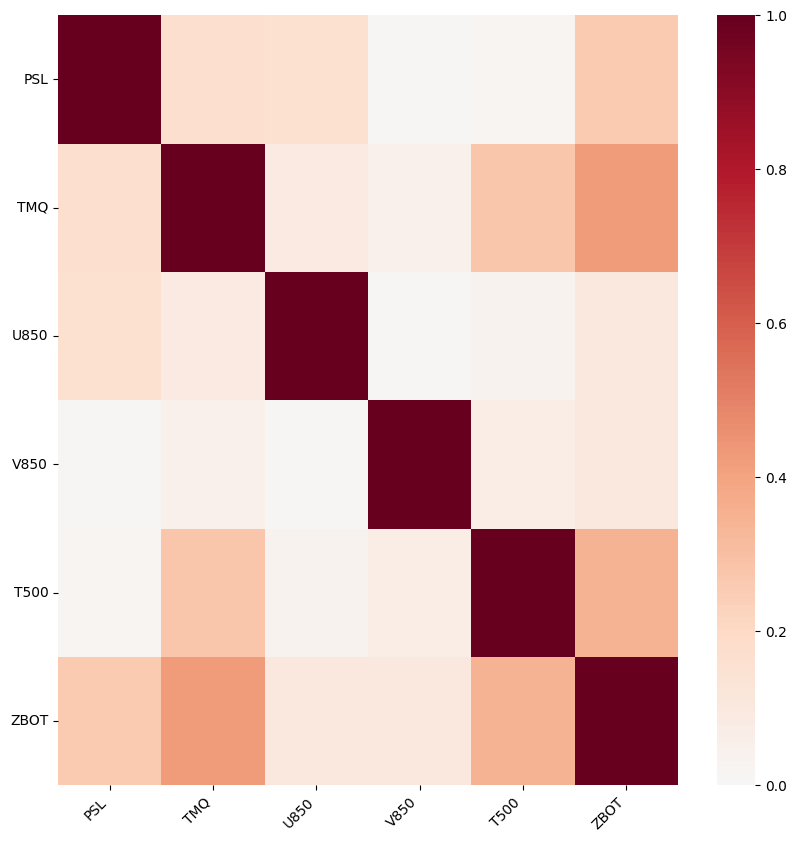

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(abs(cm_features), ax=ax, xticklabels=features, yticklabels=features, cmap='RdBu_r', center=0, vmin=0, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
plt.show()